# Makemore Part 2 — Multi-Layer Perceptron

- **Problem**: The number of features (< ~100) is much smaller than the size of the vocabulary (~17,000)
  - **Solution**: Build and train a look-up table that is shape `(num. of vocabulary, num. of features)`.
  - It takes in a vocabulary word (mapped to index $i$) and outputs a feature vector ($C(i)$)
  - The output layer has one logit for each possible (next) vocabulary word
  - `num. of features` is the row dimension because... we are indexing into the table to directly return the vocabulary word _as represented by features_.


In [ ]:
# Imports
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, reduce, repeat
%matplotlib inline

# Parameters
FILENAME = "names.txt"
CONTEXT_LEN = 3
N_FEATURES = 10
N_HIDDEN = 200
DOT = "."
SMOOTHING = 1
SEED = 2147483647

# Matrix visualisation helper
def plot_mtx(mtx, title):
  mtx = mtx.detach().numpy()
  plt.title(f"{title} {tuple(mtx.shape)}")
  plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
  sns.heatmap(mtx,
              cmap="RdBu",
              cbar=False,
              # xticklabels=[DOT] + chars,
              linewidths=0.5,
              linecolor="black",
              square=True)

# Retrieve the data
with open(FILENAME, "r") as f:
  words = f.read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [232]:
# Build vocabulary
chars = sorted(list(set("".join(words))))

stoi = {s: i+1 for i, s in enumerate(chars)}
stoi[DOT] = 0

itos = dict(zip(stoi.values(), stoi.keys()))

N_VOCAB = len(itos)

In [233]:
[0] * 3

[0, 0, 0]

In [234]:
# Build the dataset
X, Y = [], []
for w in words:
  # print(w)
  context = [0] * CONTEXT_LEN
  for ch in w + ".":
    ix = stoi[ch]
    X.append(context)  # input (context; a list of idx's)
    Y.append(ix)  # label (as index)
    # print("".join(itos[i] for i in context), "--->", itos[ix])

    context = context[1:] + [ix]  # crop front of context; append current ix

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [235]:
# Build the dataset in 80/10/10
def build_dataset(words):
  """Maps a list of words into int tensors"""
  # Build the dataset
  X, Y = [], []
  for w in words:
    context = [0] * CONTEXT_LEN
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)  # input (context; a list of idx's)
      Y.append(ix)  # label (as index)
      context = context[1:] + [ix]  # crop front of context; append current ix

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [236]:
# Example of retrieval (lookup).
# Indexing <=> one-hot row retrieval (most of the time)
def retrieval_demo(X_tensor):
  C = torch.randn((27, 2))
  print("=== Single Index ===")
  x = 5
  print("- Indexing:", C[x])
  print("- One-hot:", F.one_hot(torch.tensor(x), num_classes=27).float() @ C)

  print("\n=== List ===")
  x = [0, 1, 2]
  print("- input, shape:", x, "←", tuple(torch.tensor(x).shape))
  print("- Indexing:\n", (C[x]))
  print("- One-hot:\n", (F.one_hot(torch.tensor(x), num_classes=27).float() @ C))

  print("\n=== ! Breaks with nested lists ===")
  x = [[0, 1, 2], [0, 0, 0]]
  print("- input, shape:", x, "←", tuple(torch.tensor(x).shape))
  print("- Indexing:", (C[x]).shape)
  print("- One-hot:", (F.one_hot(torch.tensor(x), num_classes=27).float() @ C).shape)

  print("\n====== Tensor ======")
  x = X_tensor
  indexing = C[x]
  onehot = F.one_hot(x, num_classes=27).float() @ C
  print("- X.shape, C.shape:", tuple(x.shape), tuple(C.shape))
  print("- Indexing directly:", indexing.shape)
  print("- One-hot:", onehot.shape)
  print("- Equivalent elements?:", torch.all(torch.eq(indexing, onehot)).item())
  print("   - Indexing is faster and equivalent in the tensor case, here.")

# retrieval_demo(X)

In [237]:
# ------------------- All together now! ----------------------------------------

In [238]:
g = torch.Generator().manual_seed(SEED)

C = torch.randn((N_VOCAB, N_FEATURES), generator=g)
W1 = torch.randn((CONTEXT_LEN * N_FEATURES, N_HIDDEN), generator=g)
b1 = torch.randn(N_HIDDEN, generator=g)
W2 = torch.randn((N_HIDDEN, N_VOCAB), generator=g)
b2 = torch.randn(N_VOCAB, generator=g)

parameters = [C, W1, b1, W2, b2]

print("Total num. of parameters: ", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad_(True)

# ------- optional plots -------
# plot_mtx(C, "C")
# plot_mtx(W1, "W1")
# plot_mtx(b1, "b1")

Total num. of parameters:  11897


In [239]:
lre = torch.linspace(-3, 0, 1000)  # between [-3, 0]
lrs = 10**lre  # between [1e-2, 1]
lri = []
lossi = []

In [270]:
LR = 1e-1
EPOCHS = 50000
BATCH_SIZE = 32


for i in range(EPOCHS):

  # minibatch construct:
  # use X[ixs], Y[ixs], rather than X, Y
  # 0:43:49 at https://youtu.be/TCH_1BHY58I?t=2649
  # GOOD: Minibatches are computationally efficient and still transport us to desired results
  # BUT: Approximate gradient updates occasionally give unreliable direction
  # resulting in fluctuating loss (rather than strictly decreasing loss)
  ixs = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))

  # forward pass
  emb = C[Xtr[ixs]]  # (32, 3, 2)
  x1 = rearrange(emb, "ix c f -> ix (c f)")  # (32, 6)
  h = torch.tanh(x1 @ W1 + b1)
  logits = h @ W2 + b2
  # torch is MUCH more efficient and better behaved for overflows
  loss = F.cross_entropy(logits, Ytr[ixs])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  # lr = LR
  lr = 0.001
  for p in parameters:
    # p.data += -lr * p.grad
    p.data += -lr * p.grad

  # track state
  # append either `lr` or `lre[i]`. I put `i` cos I want a loss graph
  lri.append(i)
  lossi.append(loss.log10().item())

2.2213499551675073


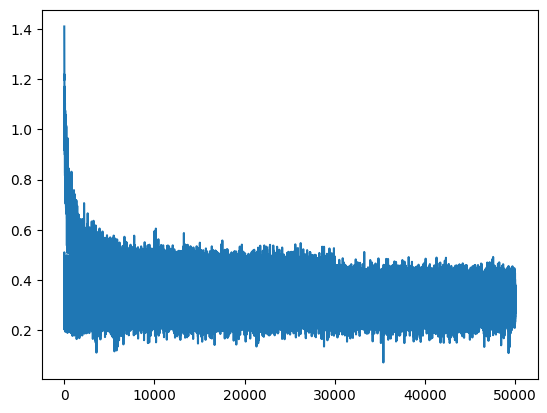

In [271]:
plt.plot(lri, lossi)
print(10**lossi[-1])

In [273]:
def forward_pass(X, Y):
  emb = C[X]  # (32, 3, 2)
  x1 = rearrange(emb, "ix c f -> ix (c f)")  # (32, 6)
  h = torch.tanh(x1 @ W1 + b1)
  logits = h @ W2 + b2
  # torch is MUCH more efficient and better behaved for overflows
  loss = F.cross_entropy(logits, Y)
  return loss.item()

print("Train loss:", forward_pass(Xtr, Ytr)) # Video, try beat: 2.1260
print("Dev loss:", forward_pass(Xdev, Ydev)) # Video, try beat: 2.1701

# RESULTS:
# Train loss: 2.128936767578125
# Dev loss: 2.1656455993652344
# Method: Train for roughly 30-50k "epochs" at a time. Manually decreasing learning rate starting from 0.1, then 0.01, then 0.001
# Configuration left at CONTEXT_LEN = 3, N_FEATURES = 10, N_HIDDEN = 200

Train loss: 2.128936767578125
Dev loss: 2.1656455993652344


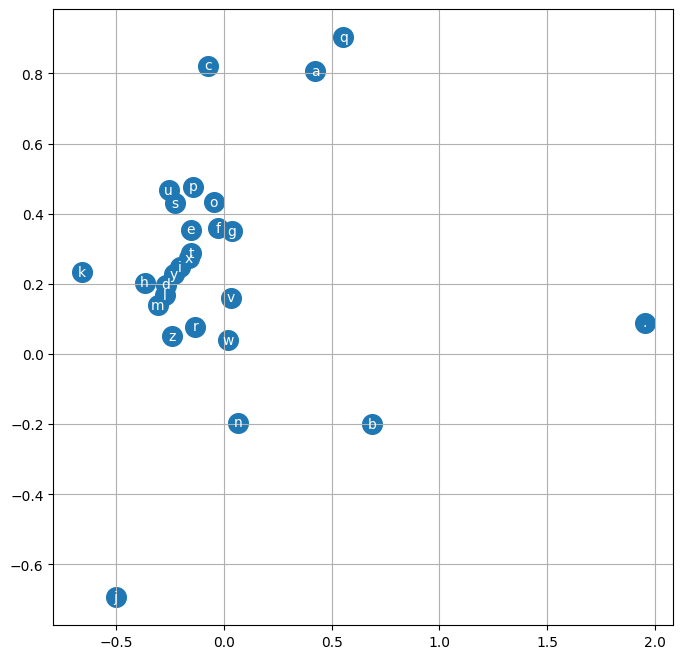

In [245]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i],
           ha="center", va="center", color="white")
plt.grid("minor")

In [252]:
generator = torch.Generator().manual_seed(SEED)
x = "..."

# Wait, training for an obscene number of epochs made for a large reduction in gibberish even though the absolute difference in loss wasn't that much.
# Seems like a small change in loss still makes a big difference

for _ in range(20):
  out = []
  context = [0] * CONTEXT_LEN
  while True:
    # forward pass
    emb = C[torch.tensor([context])]  # (CONTEXT_LEN, NUM_FEATURES)
    x1 = rearrange(emb, "ix c f -> ix (c f)")  # (1, NUM_FEATURES)
    h = torch.tanh(x1 @ W1 + b1)
    logits = h @ W2 + b2

    # predict
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, 1, True, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if (ix == 0):
      break

  print("".join(itos[i] for i in out))

ming.
hacferd.
kyrilostadi.
malkoshaivinlyn.
halee.
aviy.
gieighttene.
matiaisingianiley.
juliife.
elaydynn.
relle.
lilyn.
ali.
loleighyni.
lascut.
pemier.
adix.
kaelymaryamiie.
amr.
acomruniy.
